# **Question 3**

**3.1 For your group proposed project, you must explore some aspects of machine learning models. You must use the dataset given but you may use additional datasets to supplement your analysis (e.g., weather data).**

This project aims to develop a dynamic, data-driven pricing model for carparks to optimize revenue and enhance user experience.  By analyzing past usage patterns, entry/exit times, and demand sensitivity to price changes, we can set variable pricing tiers tailored to different carparks. This adaptive system aims to reduce congestion, improve user satisfaction, and maximize carpark usage by aligning pricing with demand patterns. Time series analysis will support demand predictions by incorporating factors like weather and events, ultimately creating a sustainable and efficient urban parking solution that benefits both operators and users.

In [ ]:
import requests
import pandas as pd
from datetime import datetime
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

**Collect Holiday Data**

In [ ]:
def collect_monthly_holiday_data(start_date, end_date, country='SG'):
    api_key = 'Wr1sZoUWH0x6YlOxbrxwKzlrvKm6u1rH'
    holidays = []

    # Set up retry logic for handling transient issues with API
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
    session.mount('https://', HTTPAdapter(max_retries=retries))

    for year in range(start_date.year, end_date.year + 1):
        print(f"Collecting holiday data for year: {year}")

        try:
            url = f'https://calendarific.com/api/v2/holidays?api_key={api_key}&country={country}&year={year}'
            response = session.get(url)

            # Check for successful response
            if response.status_code == 200:
                data = response.json()

                if data['meta']['code'] == 200:
                    holidays_data = data['response']['holidays']
                    for holiday in holidays_data:
                        holiday_name = holiday['name']
                        holiday_date = holiday['date']['iso'].split('T')[0]
                        holidays.append({'name': holiday_name, 'date': holiday_date})
                else:
                    print(f"Error collecting holiday data for {year}: {data['meta']['code']}")
            else:
                print(f"Request failed for {year} with status code: {response.status_code}")

        except Exception as e:
            print(f"Error collecting holiday data for {year}: {str(e)}")

    if holidays:  # Only process if holidays are found
        holiday_df = pd.DataFrame(holidays)
        holiday_df['date'] = pd.to_datetime(holiday_df['date']).dt.date

        # Save data to CSV
        filename = f"holiday_data_{start_date.strftime('%Y%m')}_{end_date.strftime('%Y%m')}.csv"
        holiday_df.to_csv(filename, index=False)
        print(f"Holiday data saved to {filename}")
        return holiday_df
    else:
        print("No holiday data collected.")
        return None


**Collect Carpark data**

In [ ]:
import requests
import json
from datetime import timedelta

# Function to collect carpark data for a given month and save it to a JSON file
def collect_carpark_data(start_date, end_date, filename='car_park_data'):
    all_data = []
    current_date = start_date
    retries = 3  # Number of retries for failed requests
    while current_date <= end_date:
        print(f"Collecting data for: {current_date}")

        date_str = current_date.strftime('%Y-%m-%dT%H:%M:%S')
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={date_str}'

        success = False
        attempt = 0
        while not success and attempt < retries:
            try:
                response_API = requests.get(site)
                response_API.raise_for_status()  # Raise an error for bad status codes
                data = response_API.json()

                if "items" in data and data["items"]:
                    carpark_data = data["items"][0]["carpark_data"]
                    for entry in carpark_data:
                        entry["timestamp"] = data["items"][0]["timestamp"]
                    all_data.extend(carpark_data)
                    success = True  # Successfully retrieved data
                else:
                    print(f"No carpark data found for {current_date}")
                    success = True  # Considered success even if no data is available

            except requests.RequestException as e:
                print(f"Request failed on attempt {attempt + 1}: {e}")
                attempt += 1
                if attempt == retries:
                    print(f"Failed to collect data for {current_date} after {retries} attempts.")
            except Exception as e:
                print(f"Unexpected error for {current_date}: {e}")
                break  # Break out of the loop if there's an unexpected error

        current_date += timedelta(hours=1)

    # Save file if data was collected
    if all_data:
        with open(filename, 'w') as fp:
            json.dump(all_data, fp)
        print(f"Data saved to {filename}")
    else:
        print("No data was collected during the specified period.")


**Collect Temperature data**

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def collect_temperature_data(start_date, end_date, filename='temperature.csv'):
    # API endpoint
    url = "https://api.data.gov.sg/v1/environment/air-temperature"

    # Function to generate a range of dates with the specified timedelta
    def daterange(start, end, delta):
        current = start
        while current <= end:
            yield current
            current += delta

    # List to store collected data
    collected_data = []

    # Iterate over hourly timestamps within the date range
    for dt in daterange(start_date, end_date, timedelta(hours=1)):
        timestamp = dt.isoformat()
        print(f"Collecting data for: {timestamp}")

        # Make the API request
        params = {"date_time": timestamp}
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise an exception for bad responses

            if response.status_code == 200:
                data = response.json()

                for item in data['items']:
                    timestamp = item['timestamp']
                    readings = item['readings']

                    total_temperature = 0
                    count = 0

                    # Calculate the average temperature
                    for reading in readings:
                        value = reading['value']
                        total_temperature += value
                        count += 1

                    if count > 0:
                        average_temperature = total_temperature / count

                        # Store the result for this timestamp
                        collected_data.append({
                            'timestamp': timestamp,
                            'average_temperature': average_temperature
                        })
            else:
                print(f"Failure: {response.status_code} for timestamp {timestamp}")
        except requests.RequestException as e:
            print(f"Request failed for timestamp {timestamp}: {e}")

    # Convert collected data into a DataFrame
    result_df = pd.DataFrame(collected_data)

    # Save data to CSV
    result_df.to_csv(filename, index=False)

    print(f"Data successfully saved to {filename}.")



**Collect Rainfall Data**

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def collect_rainfall_data(start_date, end_date, filename='rainfall_data.csv'):
    # API endpoint
    url = "https://api-open.data.gov.sg/v2/real-time/api/rainfall"

    # Function to generate a range of dates with the specified timedelta
    def daterange(start, end, delta):
        current = start
        while current <= end:
            yield current
            current += delta

    # List to store collected data
    collected_data = []

    # Iterate over hourly timestamps within the date range
    for dt in daterange(start_date, end_date, timedelta(hours=1)):
        timestamp = dt.isoformat()
        print(f"Collecting data for: {timestamp}")

        # Make the API request
        params = {"date": timestamp}
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()  # Raise an exception for bad responses

            if response.status_code == 200:
                data = response.json()

                for reading in data['data']['readings']:
                    timestamp = reading['timestamp']
                    total_value = 0

                    # Sum rainfall values for all stations at the timestamp
                    for station_data in reading['data']:
                        value = station_data['value']
                        total_value += value

                    # Store the result for this timestamp
                    collected_data.append({
                        'timestamp': timestamp,
                        'value': total_value
                    })
            else:
                print(f"Failure: {response.status_code} for timestamp {timestamp}")
        except requests.RequestException as e:
            print(f"Request failed for timestamp {timestamp}: {e}")

    # Convert collected data into a DataFrame
    result_df = pd.DataFrame(collected_data)

    # Save data to CSV
    result_df.to_csv(filename, index=False)

    print(f"Data successfully saved to {filename}.")



In [ ]:
import pandas as pd
from datetime import datetime


In [ ]:
# Define the training date range (e.g., January to March 2024)
start_date_train = datetime(2024, 1, 1)
end_date_train = datetime(2024, 3, 31, 23, 59, 59)

# Define the testing date range (e.g., April to June 2024)
start_date_test = datetime(2024, 4, 1)
end_date_test = datetime(2024, 6, 30, 23, 59, 59)


In [ ]:
# Collect training data for holidays
holiday_train = collect_monthly_holiday_data(start_date_train, end_date_train)
print("Training data for holidays collected.")

# Collect training data for car park occupancy
car_park_train = collect_carpark_data(start_date_train, end_date_train)
print("Training data for car park occupancy collected.")

# Collect training data for temperature
temperature_train = collect_temperature_data(start_date_train, end_date_train)
print("Training data for temperature collected.")

# Collect training data for rainfall
rainfall_train = collect_rainfall_data(start_date_train, end_date_train)
print("Training data for rainfall collected.")


In [ ]:
# Collect testing data for holidays
holiday_test = collect_monthly_holiday_data(start_date_test, end_date_test)
print("Testing data for holidays collected.")

# Collect testing data for car park occupancy
# car_park_test = collect_carpark_data(start_date_test, end_date_test)
# print("Testing data for car park occupancy collected.")

# Collect testing data for temperature
temperature_test = collect_temperature_data(start_date_test, end_date_test)
print("Testing data for temperature collected.")

# Collect testing data for rainfall
rainfall_test = collect_rainfall_data(start_date_test, end_date_test)
print("Testing data for rainfall collected.")


# Save testing data to CSV files
holiday_test.to_csv('holiday_test.csv', index=False)
car_park_test.to_csv('car_park_test.csv', index=False)
temperature_test.to_csv('temperature_test.csv', index=False)
rainfall_test.to_csv('rainfall_test.csv', index=False)

print("Training and testing data saved.")


**Prcocessing the data to get the required carpark values**

In [ ]:
import csv
from collections import defaultdict
from datetime import datetime
import ast

def process_data(input_files, output_file):
    hourly_data = defaultdict(lambda: {'total_carparks': 0, 'total_lots': 0, 'lots_available': 0})

    for input_file in input_files:
        with open(input_file, 'r') as file:

            csv_reader = csv.DictReader(file)
            for row in csv_reader:
                timestamp = row['timestamp']

                # Ensure timestamp is processed and validated
                if not timestamp:
                    print(f"Skipping row with missing or empty timestamp: {row}")
                    continue

                try:
                    parsed_timestamp = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S+08:00')
                    hour_timestamp = parsed_timestamp.strftime('%Y-%m-%dT%H:00:00+08:00')  # Hourly rounded timestamp
                except ValueError:
                    print(f"Skipping malformed timestamp: {timestamp}")
                    continue


                try:

                    carpark_info = ast.literal_eval(row['carpark_info'])
                    for item in carpark_info:
                        total_lots = int(item['total_lots'])
                        lots_available = int(item['lots_available'])

                        hourly_data[hour_timestamp]['total_carparks'] += 1
                        hourly_data[hour_timestamp]['total_lots'] += total_lots
                        hourly_data[hour_timestamp]['lots_available'] += lots_available
                except (ValueError, KeyError, SyntaxError) as e:
                    print(f"Skipping malformed data entry in row: {row} due to {e}")
                    continue

    sorted_data = sorted(hourly_data.items(), key=lambda x: datetime.strptime(x[0], '%Y-%m-%dT%H:%M:%S+08:00'))

    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['timestamp', 'total_carparks', 'total_lots', 'lots_available', 'avg_lots_available'])
        for timestamp, values in sorted_data:
            total_carparks = values['total_carparks']
            total_lots = values['total_lots']
            lots_available = values['lots_available']
            avg_lots_available = lots_available / total_carparks if total_carparks > 0 else 0
            writer.writerow([timestamp, total_carparks, total_lots, lots_available, avg_lots_available])


input_files = ['car_park_train.csv']
output_file = 'car_park_data_train.csv'
process_data(input_files, output_file)

input_files = ['car_park_test.csv']
output_file = 'car_park_data_test.csv'
process_data(input_files, output_file)




In [ ]:
import pandas as pd
from datetime import datetime, timedelta

holiday_train = pd.read_csv('holiday_train.csv')
car_park_train = pd.read_csv('car_park_data_train.csv')
temperature_train = pd.read_csv('temperature_train.csv')
rainfall_train = pd.read_csv('rainfall_train.csv')

holiday_test = pd.read_csv('holiday_test.csv')
car_park_test = pd.read_csv('car_park_data_test.csv')
temperature_test = pd.read_csv('temperature_test.csv')
rainfall_test = pd.read_csv('rainfall_test.csv')



**Collect all the datasets and load it**

**Train model and validate on validation set**

**Print the results on train and validation test**

<ipython-input-6-08860266859b>:45: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_data['is_holiday'] = train_data['timestamp'].isin(holiday_train['date'])


Validation Mean Squared Error: 5.6228
Validation R-squared: 0.9897
Feature importances:
hour: 0.18280613859547473
day_of_week: 0.010467988634318255
hour_day_interaction: 0.001795751991927204
avg_lots_available_lag1: 0.7887889477966598
avg_lots_available_lag2: 0.0031218945504164564
avg_lots_available_lag3: 0.011065914897498698
rainfall: 0.0002128832409648636
temperature: 0.0005323822617194726
rolling_temperature: 0.0006015733629926081
rolling_rainfall: 0.000603340603314914
is_holiday: 3.1840647131513817e-06
Training Mean Squared Error: 3.9798
Training R-squared: 0.9930


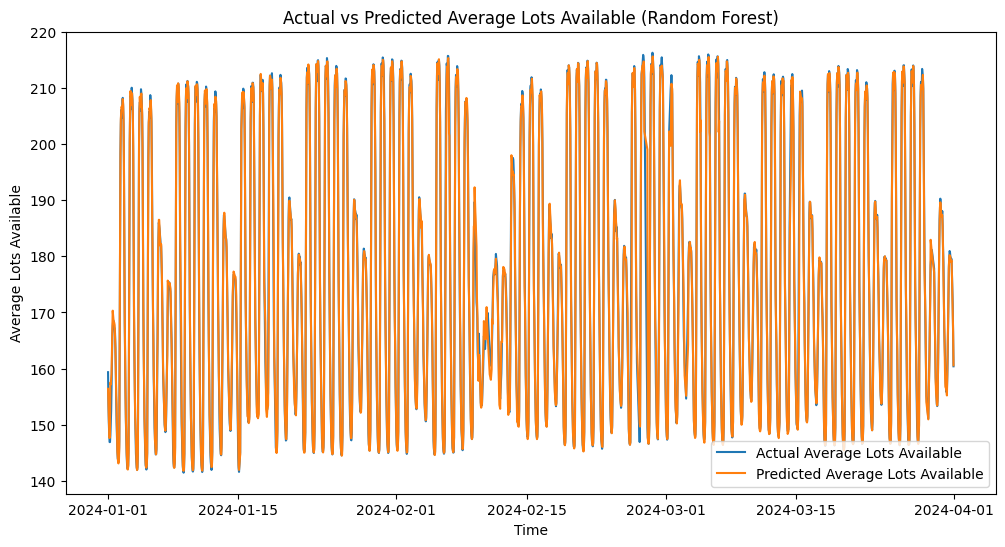

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def parse_datetime(datetime_str):
    return pd.to_datetime(datetime_str, format='%Y-%m-%dT%H:%M:%S+08:00')

# Load the training data
carpark_data_train = pd.read_csv('car_park_data_train.csv')
rainfall_data_train = pd.read_csv('rainfall_train.csv')
temperature_data_train = pd.read_csv('temperature_train.csv')

# parse the 'timestamp' column for the training data
carpark_data_train['timestamp'] = pd.to_datetime(carpark_data_train['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')
rainfall_data_train['timestamp'] = pd.to_datetime(rainfall_data_train['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')
temperature_data_train['timestamp'] = pd.to_datetime(temperature_data_train['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')

# Rename columns for consistency
rainfall_data_train = rainfall_data_train.rename(columns={'value': 'rainfall'})
temperature_data_train = temperature_data_train.rename(columns={'average_temperature': 'temperature'})

# Merge the training data on 'timestamp'
train_data = pd.merge(carpark_data_train, rainfall_data_train, on='timestamp', how='left')
train_data = pd.merge(train_data, temperature_data_train, on='timestamp', how='left')

# Create time-based features for training data
train_data['day_of_week'] = train_data['timestamp'].dt.dayofweek
train_data['hour'] = train_data['timestamp'].dt.hour
train_data['hour_day_interaction'] = train_data['hour'] * train_data['day_of_week']

# Lag features for 'avg_lots_available'
train_data['avg_lots_available_lag1'] = train_data['avg_lots_available'].shift(1).fillna(train_data['avg_lots_available'].mean())
train_data['avg_lots_available_lag2'] = train_data['avg_lots_available'].shift(2).fillna(train_data['avg_lots_available'].mean())
train_data['avg_lots_available_lag3'] = train_data['avg_lots_available'].shift(3).fillna(train_data['avg_lots_available'].mean())

# Rolling features for 'temperature' and 'rainfall'
train_data['rolling_temperature'] = train_data['temperature'].rolling(window=3, min_periods=1).mean()
train_data['rolling_rainfall'] = train_data['rainfall'].rolling(window=3, min_periods=1).mean()

# Add holiday flag
train_data['is_holiday'] = train_data['timestamp'].isin(holiday_train['date'])

# Drop rows with missing target variable
train_data.dropna(subset=['avg_lots_available'], inplace=True)

# Define features and target variable for training
features = ['hour', 'day_of_week', 'hour_day_interaction', 'avg_lots_available_lag1', 'avg_lots_available_lag2',
            'avg_lots_available_lag3', 'rainfall', 'temperature', 'rolling_temperature', 'rolling_rainfall', 'is_holiday']
X_train = train_data[features]
y_train = train_data['avg_lots_available']

# Handle missing values with imputation for features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Train-Test split (for cross-validation, to monitor performance)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_imputed, y_train, test_size=0.2, random_state=42)

# Train the RandomForestRegressor with more trees
rf_model = RandomForestRegressor(
    n_estimators=500,  # Increased number of trees
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features=None,
    random_state=42
)

rf_model.fit(X_train_final, y_train_final)

# Evaluate on validation set
y_val_pred = rf_model.predict(X_val_final)
mse_val = mean_squared_error(y_val_final, y_val_pred)
r2_val = r2_score(y_val_final, y_val_pred)
print(f"Validation Mean Squared Error: {mse_val:.4f}")
print(f"Validation R-squared: {r2_val:.4f}")

# Feature Importances
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, feature_importances))
print("Feature importances:")
for feature, importance in importance_dict.items():
    print(f"{feature}: {importance}")

# Predict on the full training data
y_train_pred = rf_model.predict(X_train_imputed)

# Evaluate on full training data
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f"Training Mean Squared Error: {mse_train:.4f}")
print(f"Training R-squared: {r2_train:.4f}")

# Plot actual vs predicted values on the full training data
plt.figure(figsize=(12, 6))
plt.plot(train_data['timestamp'], y_train, label='Actual Average Lots Available')
plt.plot(train_data['timestamp'], y_train_pred, label='Predicted Average Lots Available')
plt.xlabel('Time')
plt.ylabel('Average Lots Available')
plt.title('Actual vs Predicted Average Lots Available (Random Forest)')
plt.legend()
plt.show()


**Test the model on test dataset**

**Print the results**

<ipython-input-7-489848c27851>:59: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data['is_holiday'] = data['timestamp'].isin(holiday_train['date'])
<ipython-input-7-489848c27851>:59: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data['is_holiday'] = data['timestamp'].isin(holiday_train['date'])
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters from GridSearch: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Mean Squared Error: 7.7460
Test R-squared: 0.9861
Feature importances:
hour: 0.18944578575078103
day_of_week: 0.01142427657273982
hour_day_interaction: 0.002289293592890342
avg_lots_available_lag1: 0.7799829547657675
avg_lots_available_lag2: 0.003622748887148263
avg_lots_available_lag3: 0.011099805710945322
rainfall: 0.0001979625938676763
temperature: 0.0005940927815642026
rolling_temperature: 0.0006589688500043803
rolling_rainfall: 0.0006770985072700197
is_holiday: 7.011987021480182e-06


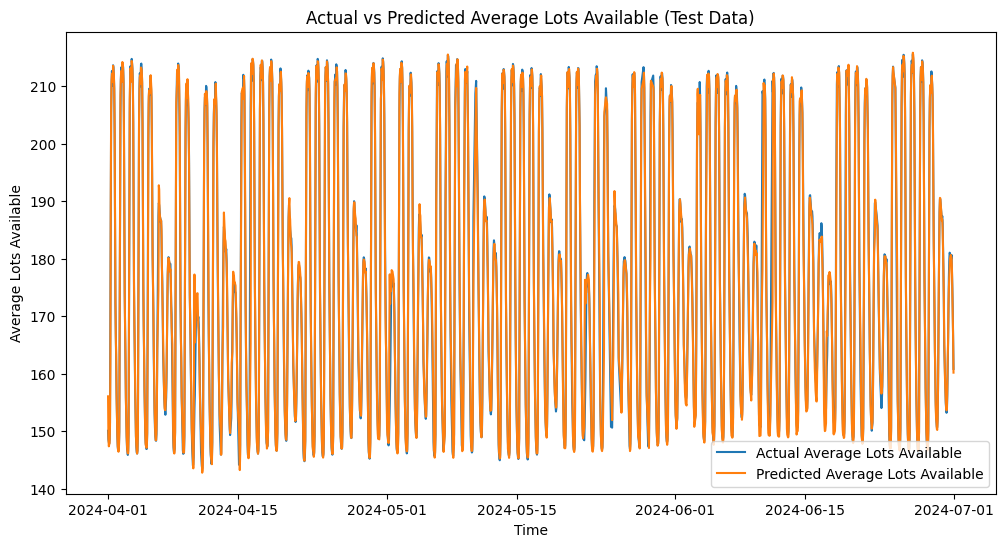

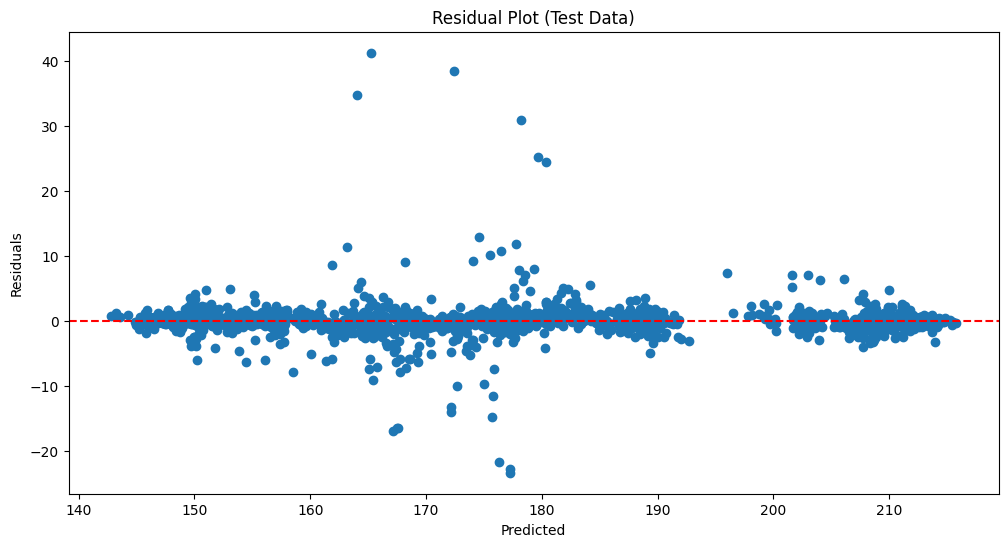

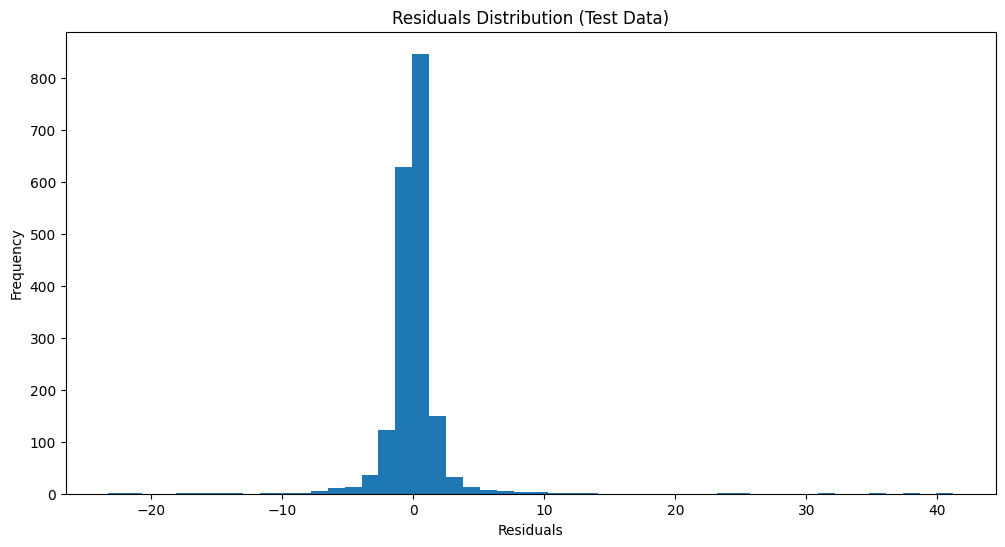

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

def parse_datetime(datetime_str):
    return pd.to_datetime(datetime_str, format='%Y-%m-%dT%H:%M:%S+08:00')

# Load the training and test data
carpark_data_train = pd.read_csv('car_park_data_train.csv')
rainfall_data_train = pd.read_csv('rainfall_train.csv')
temperature_data_train = pd.read_csv('temperature_train.csv')
carpark_data_test = pd.read_csv('car_park_data_test.csv')
rainfall_data_test = pd.read_csv('rainfall_test.csv')
temperature_data_test = pd.read_csv('temperature_test.csv')

# parse the 'timestamp' column for both train and test data
carpark_data_train['timestamp'] = pd.to_datetime(carpark_data_train['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')
rainfall_data_train['timestamp'] = pd.to_datetime(rainfall_data_train['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')
temperature_data_train['timestamp'] = pd.to_datetime(temperature_data_train['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')

carpark_data_test['timestamp'] = pd.to_datetime(carpark_data_test['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')
rainfall_data_test['timestamp'] = pd.to_datetime(rainfall_data_test['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')
temperature_data_test['timestamp'] = pd.to_datetime(temperature_data_test['timestamp'], format='%Y-%m-%dT%H:%M:%S+08:00')

# Rename columns for consistency
rainfall_data_train = rainfall_data_train.rename(columns={'value': 'rainfall'})
temperature_data_train = temperature_data_train.rename(columns={'average_temperature': 'temperature'})
rainfall_data_test = rainfall_data_test.rename(columns={'value': 'rainfall'})
temperature_data_test = temperature_data_test.rename(columns={'average_temperature': 'temperature'})

# Merge the training data on 'timestamp'
train_data = pd.merge(carpark_data_train, rainfall_data_train, on='timestamp', how='left')
train_data = pd.merge(train_data, temperature_data_train, on='timestamp', how='left')

# Merge the test data on 'timestamp'
test_data = pd.merge(carpark_data_test, rainfall_data_test, on='timestamp', how='left')
test_data = pd.merge(test_data, temperature_data_test, on='timestamp', how='left')

# Create time-based features for training and test data
for data in [train_data, test_data]:
    data['day_of_week'] = data['timestamp'].dt.dayofweek
    data['hour'] = data['timestamp'].dt.hour
    data['hour_day_interaction'] = data['hour'] * data['day_of_week']

    # Lag features for 'avg_lots_available'
    data['avg_lots_available_lag1'] = data['avg_lots_available'].shift(1).fillna(data['avg_lots_available'].mean())
    data['avg_lots_available_lag2'] = data['avg_lots_available'].shift(2).fillna(data['avg_lots_available'].mean())
    data['avg_lots_available_lag3'] = data['avg_lots_available'].shift(3).fillna(data['avg_lots_available'].mean())

    # Rolling features for 'temperature' and 'rainfall'
    data['rolling_temperature'] = data['temperature'].rolling(window=3, min_periods=1).mean()
    data['rolling_rainfall'] = data['rainfall'].rolling(window=3, min_periods=1).mean()

    data['is_holiday'] = data['timestamp'].isin(holiday_train['date'])

# Drop rows with missing target variable
train_data.dropna(subset=['avg_lots_available'], inplace=True)

# Define features and target variable for training
features = ['hour', 'day_of_week', 'hour_day_interaction', 'avg_lots_available_lag1', 'avg_lots_available_lag2',
            'avg_lots_available_lag3', 'rainfall', 'temperature', 'rolling_temperature', 'rolling_rainfall', 'is_holiday']
X_train = train_data[features]
y_train = train_data['avg_lots_available']

X_test = test_data[features]
y_test = test_data['avg_lots_available']

# Handle missing values with imputation for features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Hyperparameter tuning using GridSearchCV with TimeSeriesSplit
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

tscv = TimeSeriesSplit(n_splits=5)

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Train with grid search
grid_search.fit(X_train_imputed, y_train)
best_rf_model = grid_search.best_estimator_

# Output the best parameters from GridSearch
print("Best Parameters from GridSearch:", grid_search.best_params_)

# Evaluate on test set
y_test_pred = best_rf_model.predict(X_test_imputed)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"Test Mean Squared Error: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.4f}")

# Feature Importances
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, feature_importances))
print("Feature importances:")
for feature, importance in importance_dict.items():
    print(f"{feature}: {importance}")

# Plot actual vs predicted values on the test data
plt.figure(figsize=(12, 6))
plt.plot(test_data['timestamp'], y_test, label='Actual Average Lots Available')
plt.plot(test_data['timestamp'], y_test_pred, label='Predicted Average Lots Available')
plt.xlabel('Time')
plt.ylabel('Average Lots Available')
plt.title('Actual vs Predicted Average Lots Available (Test Data)')
plt.legend()
plt.show()

# Plot residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot (Test Data)')
plt.show()

# Plot error distribution
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution (Test Data)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


Total Revenue (Test): 573050.89


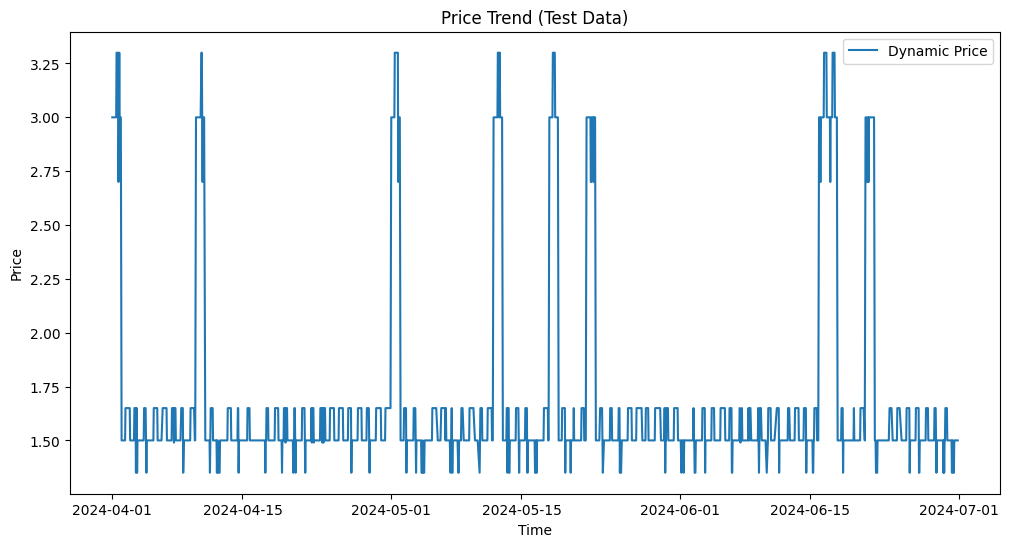

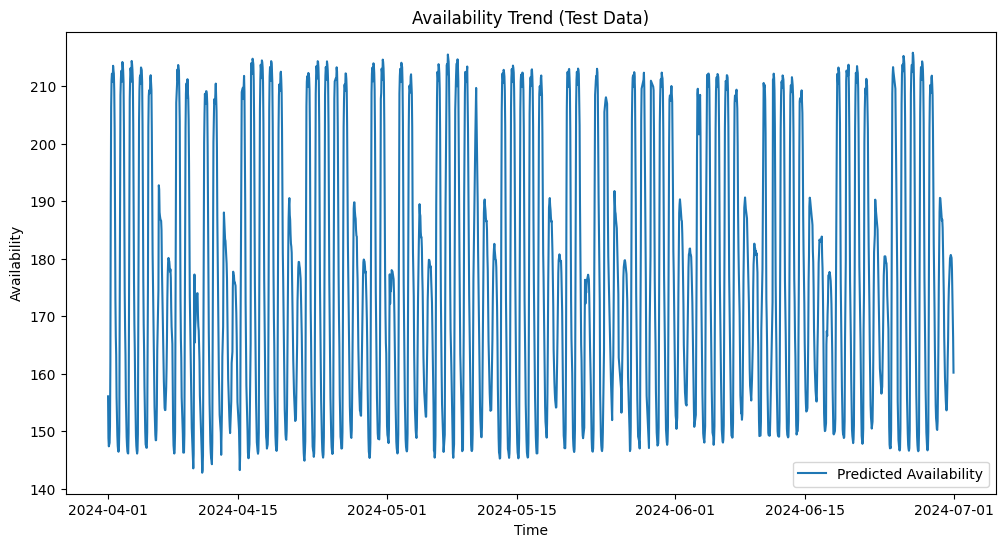

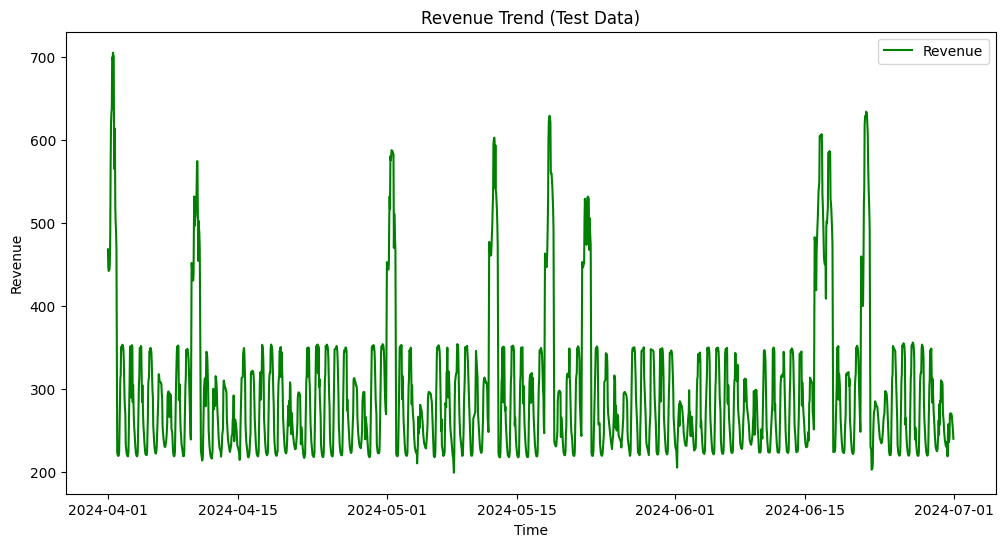

In [ ]:

# Use the Random Forest model to predict 'avg_lots_available' for the test set
test_data['predicted_lots_available'] = best_rf_model.predict(X_test_imputed)

# Define the dynamic pricing strategy function
def pricing_strategy(row, holiday_data):
    base_price = 1.5
    availability = row['predicted_lots_available']
    temperature = row['temperature']
    rainfall = row['rainfall']
    timestamp = row['timestamp']

    # Pricing logic based on availability
    if availability < 0.2:
        price = base_price * 1.5
    elif availability < 0.4:
        price = base_price * 1.3
    elif availability < 0.6:
        price = base_price * 1.1
    else:
        price = base_price

    # Adjust for temperature
    if temperature > 30:
        price *= 1.1
    elif temperature < 20:
        price *= 0.9

    # Adjust for rainfall
    if rainfall > 10:
        price *= 0.9

    # Adjust for holidays (multiply by 2 if holiday)
    if timestamp.date() in holiday_data['date'].dt.date.values:
        price *= 2

    return round(price, 2)

holiday_test['date'] = pd.to_datetime(holiday_test['date'], errors='coerce')

test_data['price'] = test_data.apply(pricing_strategy, axis=1, holiday_data=holiday_test)

test_data['revenue'] = test_data['price'] * test_data['predicted_lots_available']
total_revenue_test = test_data['revenue'].sum()

print(f"Total Revenue (Test): {total_revenue_test:.2f}")

# Step 5: Visualize the Price Trend
plt.figure(figsize=(12, 6))
plt.plot(test_data['timestamp'], test_data['price'], label='Dynamic Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Trend (Test Data)')
plt.legend()
plt.show()

# Step 6: Visualize the Availability Trend
plt.figure(figsize=(12, 6))
plt.plot(test_data['timestamp'], test_data['predicted_lots_available'], label='Predicted Availability')
plt.xlabel('Time')
plt.ylabel('Availability')
plt.title('Availability Trend (Test Data)')
plt.legend()
plt.show()

# Step 7: Visualize the Revenue Trend
plt.figure(figsize=(12, 6))
plt.plot(test_data['timestamp'], test_data['revenue'], label='Revenue', color='green')
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.title('Revenue Trend (Test Data)')
plt.legend()
plt.show()



# **Question 3.2**

### Practical Action to Benefit Society

Based on the insights derived from our analysis, a practical action that can be taken is to implement a **dynamic pricing application** integrated with real-time carpark availability updates. This application would display real-time parking rates and availability for different carparks, encouraging drivers to make informed decisions based on their budget and convenience. For instance, during peak hours, the application can suggest nearby carparks with lower demand and discounted rates, thereby redistributing traffic and reducing congestion.

To maximize user engagement, the application could include features such as personalized parking suggestions based on driver habits, pre-booking options for guaranteed parking during busy periods, and loyalty rewards for frequent users. Additionally, it could integrate with navigation tools to provide optimized routes to available spaces, saving time and reducing fuel consumption.

By providing transparent, user-friendly access to parking information, this solution benefits society by reducing traffic congestion, lowering emissions from idling cars searching for parking, and improving the overall urban mobility experience. It also supports sustainable city development by encouraging equitable usage of parking spaces and better demand management, aligning with smart city initiatives.